In [2]:
import pandas as pd

In [ ]:
df = pd.read_csv('2016.csv', parse_dates=True, index_col='Date Time')
xt = df['T (degC)']
xt = xt.reset_index(drop=True)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler

In [6]:
# Normalize the data
scaler = MinMaxScaler()
xt_scaled = scaler.fit_transform(xt.values.reshape(-1, 1)).flatten()

In [7]:
# Split into train (80%) and validation (20%) datasets
split_index = int(len(xt_scaled) * 0.8)
train, val = xt_scaled[:split_index], xt_scaled[split_index:]

In [8]:
# Create sequences for one-step prediction
def create_sequences(data, window_size=44):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 44
X_train, y_train = create_sequences(train, window_size)
X_val, y_val = create_sequences(val, window_size)

In [9]:
# Reshape input for RNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

In [10]:
# Build RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [11]:
# Train the model
model.fit(X_train, y_train, epochs=7, batch_size=74, validation_data=(X_val, y_val))

Epoch 1/7
4546/4546 [==============================] - 19s 4ms/step - loss: 4.1606e-04 - val_loss: 3.5358e-05
Epoch 2/7
4546/4546 [==============================] - 18s 4ms/step - loss: 2.8354e-05 - val_loss: 1.7221e-05
Epoch 3/7
4546/4546 [==============================] - 20s 4ms/step - loss: 1.6002e-05 - val_loss: 1.4930e-05
Epoch 4/7
4546/4546 [==============================] - 19s 4ms/step - loss: 1.3369e-05 - val_loss: 1.1662e-05
Epoch 5/7
4546/4546 [==============================] - 18s 4ms/step - loss: 1.2853e-05 - val_loss: 1.2037e-05
Epoch 6/7
4546/4546 [==============================] - 18s 4ms/step - loss: 1.2650e-05 - val_loss: 1.8587e-05
Epoch 7/7
4546/4546 [==============================] - 18s 4ms/step - loss: 1.2632e-05 - val_loss: 1.2179e-05


In [12]:
# Make predictions on the validation set
preds = model.predict(X_val)

2628/2628 [==============================] - 4s 2ms/step


In [13]:
# Inverse scale predictions
y_val_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
preds_unscaled = scaler.inverse_transform(preds).flatten()

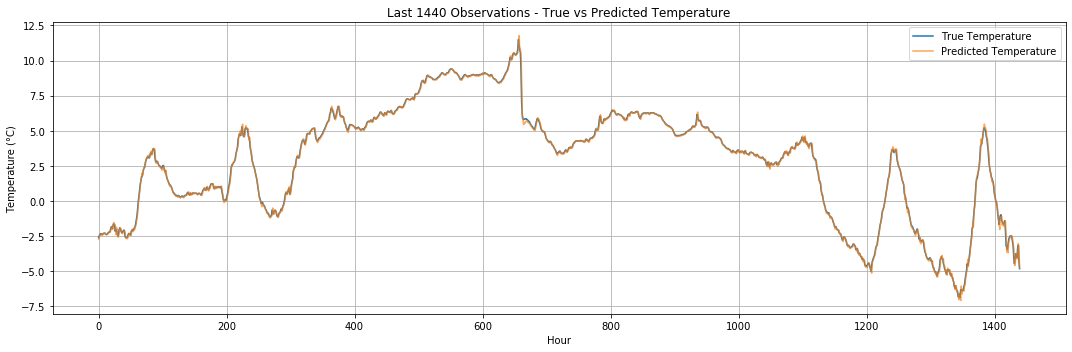

In [ ]:
# Plot last 1440 observations
n_plot = 1440
plt.figure(figsize=(15, 5))
plt.plot(y_val_unscaled[-n_plot:], label='True Temperature')
plt.plot(preds_unscaled[-n_plot:], label='Predicted Temperature', alpha=0.7)
plt.title("True vs Predicted Temperature")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()